In [10]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt

from script.sahr_fin_flutter import calculate_flutter_velocity as sahr_cfv, list_of_flutter_velocities
import numpy as np
import pandas as pd

from script.howard_fin_flutter import calculate_flutter_velocity as howard_cfv
import sys

sys.path.append("..")  # Adds the parent directory to the system pat

# Manual


In [11]:
ALTITUDE = 3048  # in m
SHEAR_MODULUS = 5000000000  # in Pa
THICKNESS = 4  # in mm
ROOT_CHORD = 300  # in mm
TIP_CHORD = 100  # in mm
SEMI_SPAN = 140  # in mm
SEA_LEVEL_SOUND = 340  # in m/s
SEA_LEVEL_PRESSURE = 101325  # in Pa
ATMOSPHERIC_SCALE_HEIGHT = 8077  # m
THICKNESS_INCREMENTS = 0.01 # in mm
MAXIMUM_THICKNESS = 5
MINIMUM_THICKNESS = 0

UNITS = 'SI' # or 'IMPERIAL'

## SI to Imperial Conversion

In [12]:
METRES_TO_FEET = 3.28084
MILLIMETRES_TO_INCHES = 0.0393701
PA_TO_PSI=0.000145038

In [13]:
def get_parameters_for_functions(units='SI'):
    if units.upper() == 'SI':
        # Convert SI units to Imperial for howard_cfv
        altitude_howard = ALTITUDE * METRES_TO_FEET
        shear_modulus_howard = SHEAR_MODULUS * PA_TO_PSI
        thickness_howard = THICKNESS * MILLIMETRES_TO_INCHES
        root_chord_howard = ROOT_CHORD * MILLIMETRES_TO_INCHES
        tip_chord_howard = TIP_CHORD * MILLIMETRES_TO_INCHES
        semispan_howard = SEMI_SPAN * MILLIMETRES_TO_INCHES

        # Use SI units for sahr_cfv
        altitude_sahr = ALTITUDE
        shear_modulus_sahr = SHEAR_MODULUS
        thickness_sahr = THICKNESS
        root_chord_sahr = ROOT_CHORD
        tip_chord_sahr = TIP_CHORD
        semispan_sahr = SEMI_SPAN

    elif units.upper() == 'IMPERIAL':
        # Use Imperial units for howard_cfv
        altitude_howard = ALTITUDE
        shear_modulus_howard = SHEAR_MODULUS
        thickness_howard = THICKNESS
        root_chord_howard = ROOT_CHORD
        tip_chord_howard = TIP_CHORD
        semispan_howard = SEMI_SPAN

        # Convert Imperial units to SI for sahr_cfv
        altitude_sahr = ALTITUDE
        shear_modulus_sahr = SHEAR_MODULUS
        thickness_sahr = THICKNESS
        root_chord_sahr = ROOT_CHORD
        tip_chord_sahr = TIP_CHORD
        semispan_sahr = SEMI_SPAN

    else:
        raise ValueError("Invalid unit system. Choose 'SI' or 'Imperial'.")

    return {
        'howard_cfv': {
            'altitude': altitude_howard,
            'shear_modulus': shear_modulus_howard,
            'thickness': thickness_howard,
            'root_chord': root_chord_howard,
            'tip_chord': tip_chord_howard,
            'semispan': semispan_howard
        },
        'sahr_cfv': {
            'sea_level_speed_of_sound': SEA_LEVEL_SOUND,
            'altitude': altitude_sahr,
            'atmospheric_scale_height': ATMOSPHERIC_SCALE_HEIGHT,
            'shear_modulus': shear_modulus_sahr,
            'sea_level_pressure': SEA_LEVEL_PRESSURE,
            'thickness': thickness_sahr,
            'root_chord': root_chord_sahr,
            'tip_chord': tip_chord_sahr,
            'semispan': semispan_sahr
        },
        'sahr_flutter_velocity_list': {
            # Exclude 'thickness' if it's not needed
            'sea_level_speed_of_sound': SEA_LEVEL_SOUND,
            'altitude': altitude_sahr,
            'atmospheric_scale_height': ATMOSPHERIC_SCALE_HEIGHT,
            'shear_modulus': shear_modulus_sahr,
            'sea_level_pressure': SEA_LEVEL_PRESSURE,
            'root_chord': root_chord_sahr,
            'tip_chord': tip_chord_sahr,
            'semispan': semispan_sahr
        }
    }


params = get_parameters_for_functions(UNITS)

# Howard Flutter Velocity


In [14]:
howard_result = howard_cfv(
    **params['howard_cfv']) / (METRES_TO_FEET if UNITS == 'SI' else 1)
print(howard_result)

402.31688469701913


# Sahr Flutter Velocity


In [15]:
sahr_result = sahr_cfv(**params['sahr_cfv'])
print(sahr_result)

401.84737525224915


In [16]:
lofv = list_of_flutter_velocities(
    MINIMUM_THICKNESS, MAXIMUM_THICKNESS, THICKNESS_INCREMENTS, **params['sahr_flutter_velocity_list'])

In [17]:
# Create array of thickness values
thicknesses_array = np.arange(
    MINIMUM_THICKNESS, MAXIMUM_THICKNESS + THICKNESS_INCREMENTS, THICKNESS_INCREMENTS)

NameError: name 'MAX_VELOCITY' is not defined

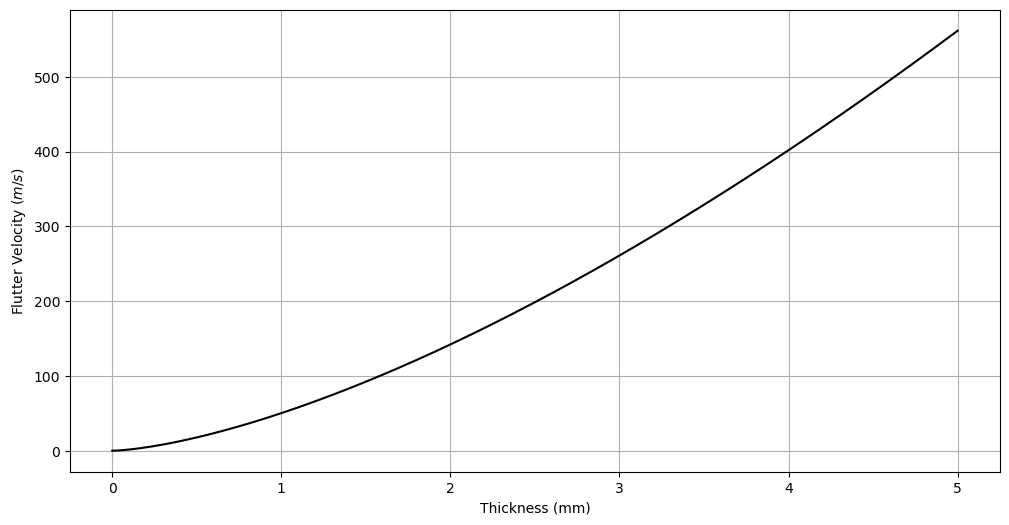

In [18]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel(r"Thickness (mm)")
ax1.set_ylabel(r"Flutter Velocity ($m/s$)")
ax1.grid(True)
ax1.plot(thicknesses_array,
         lofv, color='k', label="Flutter")
# ax1.set_ylim(min_drag_rounded, max_drag_rounded)
# ax1.set_xlim(0, max_mach)
ax1.plot()

# Max Valocity:
# Plot a horizontal line at Max Valocity:
ax1.axhline(y=MAX_VELOCITY, color='r', linestyle='-', label='Max Velocity')

# Plot a vertical line at a specific x-value, for example x = 10
ax1.axvline(x=THICKNESS, color='b', linestyle='-', label='Thickness')



# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# ax1.set_yticks(np.arange(0, max_drag+0.1, 0.05))

# Plot event markers
# self.plot_event_markers_mach(ax1)

plt.show()